In [1]:
# Cell 1: Imports & Settings
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    roc_curve, roc_auc_score
)


In [6]:
# Cell 2: Load & Filter Data, Map Target, Grade & Term
df = pd.read_csv("accepted_2007_to_2018Q4.csv")

# Keep only final statuses
df = df[df['loan_status'].isin(['Fully Paid','Charged Off'])]

# Binary target
df['target'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# Numeric grade A→0 … G→6
grade_map = {g: i for i, g in enumerate(['A','B','C','D','E','F','G'])}
df['grade'] = df['grade'].map(grade_map)

# **Convert term** from strings to ints
df['term'] = df['term'].str.extract(r'(\d+)').astype(int)


<ipython-input-6-ca6cbcd52f23>:2: DtypeWarning: Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("accepted_2007_to_2018Q4.csv")


In [7]:
# Cell 3: Prepare Features & Train/Test Split
features = ['int_rate','grade','term']
X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (716006, 3) Test: (179002, 3)


In [8]:
# Cell 4: Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=['Paid','Charged Off']))

# Coefficients
coef_df = pd.DataFrame({'feature':features, 'coef':lr.coef_[0]})
print("\nCoefficients:\n", coef_df)


=== Logistic Regression ===
Accuracy: 0.6889587825834348
F1-score: 0.42468768405716234
              precision    recall  f1-score   support

        Paid       0.87      0.72      0.79    142565
 Charged Off       0.34      0.56      0.42     36437

    accuracy                           0.69    179002
   macro avg       0.60      0.64      0.61    179002
weighted avg       0.76      0.69      0.71    179002


Coefficients:
     feature      coef
0  int_rate  0.071794
1     grade  0.231554
2      term  0.019545


In [9]:
# Cell 5: Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=['Paid','Charged Off']))

# Feature importances
imp_df = pd.DataFrame({'feature':features, 'importance':rf.feature_importances_})
print("\nFeature Importances:\n", imp_df)


=== Random Forest ===
Accuracy: 0.6476575680718651
F1-score: 0.4320576316974336
              precision    recall  f1-score   support

        Paid       0.88      0.64      0.74    142565
 Charged Off       0.32      0.66      0.43     36437

    accuracy                           0.65    179002
   macro avg       0.60      0.65      0.59    179002
weighted avg       0.77      0.65      0.68    179002


Feature Importances:
     feature  importance
0  int_rate    0.451989
1     grade    0.379146
2      term    0.168865


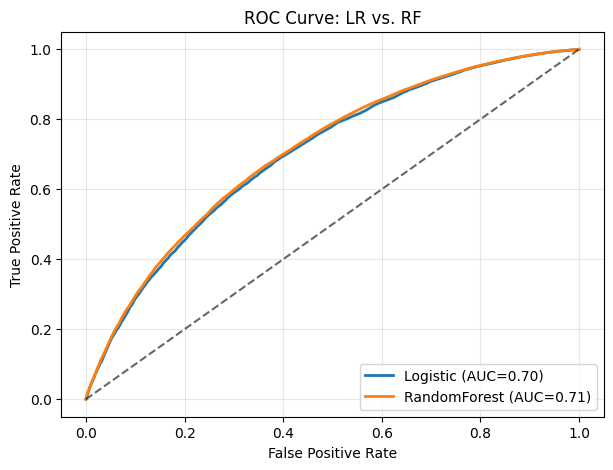

In [10]:
# Cell 6: ROC Curve Comparison
y_prob_lr = lr.predict_proba(X_test)[:,1]
y_prob_rf = rf.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={roc_auc_score(y_test,y_prob_lr):.2f})", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_score(y_test,y_prob_rf):.2f})", linewidth=2)
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: LR vs. RF")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


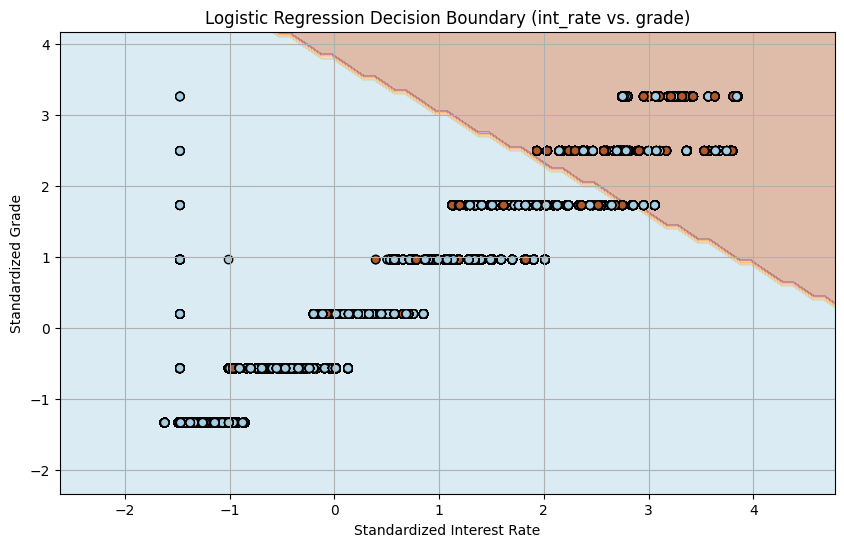

In [11]:
# Visualize logistic regression decision boundary using int_rate and grade
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Extract 2D features and target
X_2d = df[['int_rate', 'grade']]
y_2d = df['target']

# Standardize features for better scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_2d)

# Generate grid for plotting decision boundary
h = 0.1
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# Use a fresh logistic regression model for 2D projection
log_vis = LogisticRegression(max_iter=1000)
log_vis.fit(X_scaled, y_2d)
Z = log_vis.predict(grid).reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Paired)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_2d, cmap=plt.cm.Paired, edgecolors='k')
plt.title('Logistic Regression Decision Boundary (int_rate vs. grade)')
plt.xlabel('Standardized Interest Rate')
plt.ylabel('Standardized Grade')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


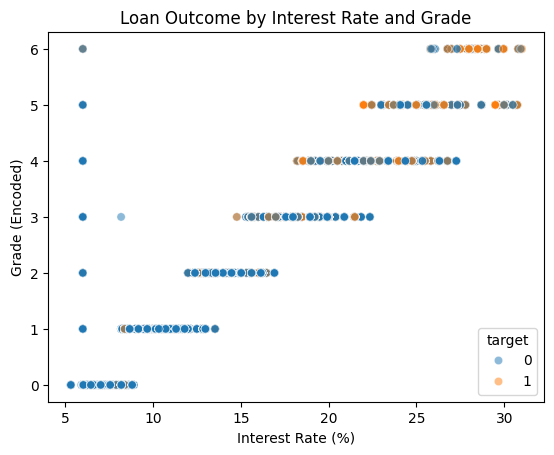

,int_rate,term,expected_pv
0,13.99,36,292630.626869
1,11.99,36,301118.349169
2,10.78,60,462259.556885
4,22.45,60,358739.575226
5,13.44,36,294930.667850


In [13]:
import seaborn as sns
# Scatter plot to show outcome distribution
sns.scatterplot(x='int_rate', y='grade', hue='target', data=df, alpha=0.5)
plt.title('Loan Outcome by Interest Rate and Grade')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Grade (Encoded)')
plt.show()

# Present Value of expected loan payments (simple annuity model)
def present_value(rate, term_months, principal=10000):
    monthly_rate = rate / 100 / 12
    n = term_months
    return principal * (1 - (1 + monthly_rate)**-n) / monthly_rate



df['expected_pv'] = df.apply(lambda row: present_value(row['int_rate'], row['term']), axis=1)
df[['int_rate', 'term', 'expected_pv']].head()
